# Classifying Chest X-Ray Images (Pneumonia)
### Markowitz Working NB

Dataset from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [65]:
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

%matplotlib inline

## Loading images from local folders

The original `val` folder from Kaggle contained only 8 images *each* from Normal and Pneumonia, which is not a sufficient size for validation. 

Rather than adding files to that folder to increase the size of the validation set, we have chosen to move **all** images into the `train` folder. We will then use the `val_split` parameter in `flow_from_directory` to instantiate a validation set.

In [3]:
# Filepaths
train_dir = 'chest_xray/train'
# validation_dir = 'chest_xray/val/'
test_dir = 'chest_xray/test/' 

In [4]:
# Check functionality and num images
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')
train_normal_dir

'chest_xray/train/NORMAL'

In [5]:
# Delete metadata files created by Mac OS
!find . -name ".DS_Store" -delete

In [6]:
print('There are', len(os.listdir(train_normal_dir)), 'normal images in the training set')
print('There are', len(os.listdir(train_pneumonia_dir)), 'pneumonia images in the training set')

There are 1349 normal images in the training set
There are 3883 pneumonia images in the training set


### EDA: Image Samples and Metadata

In [7]:
# Get list of filenames of all training images
train_norm_filenames = os.listdir(train_normal_dir)
train_pneum_filenames = os.listdir(train_pneumonia_dir)

In [8]:
# Make list of full filepaths to each image
train_normal_filepaths = [os.path.join(train_normal_dir, name) for name in train_norm_filenames]
train_pneumonia_filepaths = [os.path.join(train_pneumonia_dir, name) for name in train_pneum_filenames]

In [9]:
train_normal_filepaths[:10]

['chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg',
 'chest_xray/train/NORMAL/IM-0427-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg',
 'chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg',
 'chest_xray/train/NORMAL/IM-0561-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-1110-0001.jpeg',
 'chest_xray/train/NORMAL/IM-0757-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-1326-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-0736-0001.jpeg']

In [10]:
# Read each file in as an image
train_normal_images = [mpimg.imread(img) for img in train_normal_filepaths]
train_normal_images[0]

array([[ 0, 23, 24, ...,  0,  0,  0],
       [ 0,  5, 23, ...,  0,  0,  0],
       [ 1,  0, 26, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

In [11]:
def get_images(filepath):
    '''
    Given a filepath for a folder of images, return a list of those images
    as arrays of dtype=uint8.
    '''
    # List of filenames
    filenames = os.listdir(filepath)
    # List of full filepaths to each image
    filepaths = [os.path.join(filepath, name) for name in filenames]
    # Return list of files as raw image arrays
    return [mpimg.imread(img) for img in filepaths]

In [12]:
# Get training images of normal and pneumonia
train_normal_images = get_images(train_normal_dir)
train_pneumonia_images = get_images(train_pneumonia_dir)

#### Show the first 5 images from each set:

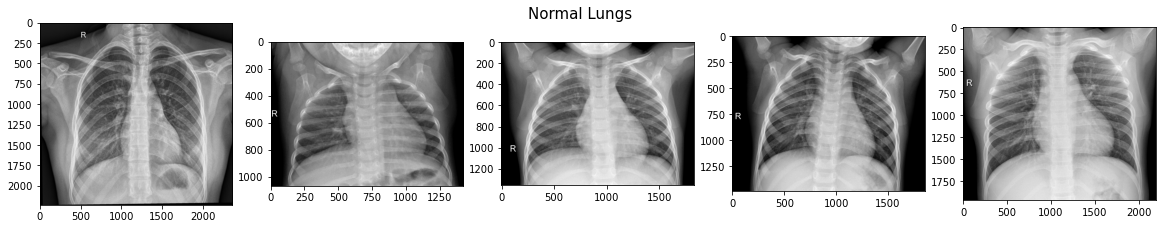

In [13]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.imshow(train_normal_images[i], cmap='gray')
fig.suptitle('Normal Lungs', fontsize=15, y=.8)
fig.tight_layout;

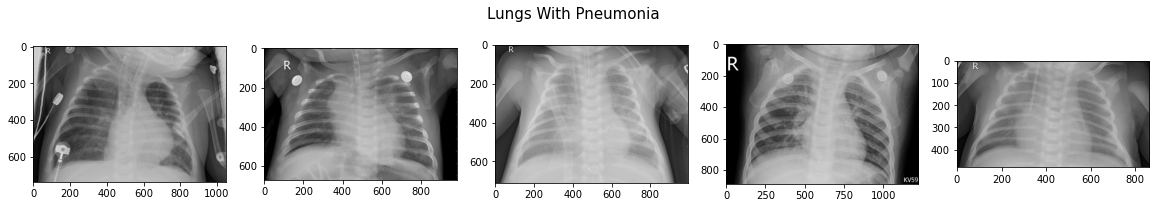

In [14]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.imshow(train_pneumonia_images[i], cmap='gray')
fig.suptitle('Lungs With Pneumonia', fontsize=15, y=.8)
fig.tight_layout;

**Notes:**
 - All photos are single-channel (black and white, not RGB)
 - All x-ray photos have 'R' to designate right-side lung
 - Pneumonia lungs have EKG(?) electrodes(?)--possible confounding factor for NN?
 - Pneumonia lungs look "cloudy" or "fuzzy" compared to Normal

From Kaggle:
> The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.

Essentially, this means that bacterial pneumonia typically gathers in one area of the lungs, while viral penumonia is more spread out.

#### Metadata

In [15]:
# Dimensions of images
normal_img_shapes = [img.shape for img in train_normal_images]
pneumonia_img_shapes = [img.shape for img in train_pneumonia_images]

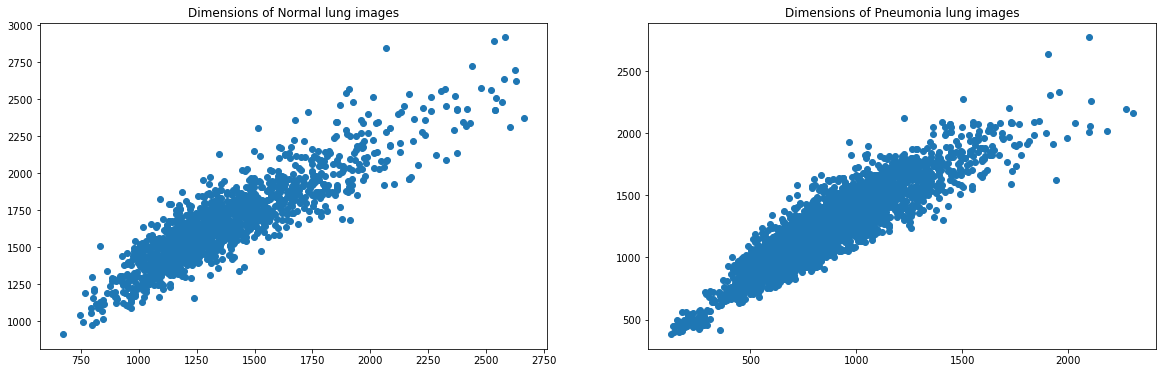

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Sizes of Normal lung images
ax1.scatter(x=[x[0] for x in normal_img_shapes], y=[x[1] for x in normal_img_shapes])
ax1.set_title('Dimensions of Normal lung images')

# Sizes of Pneumonia lung images
ax2.scatter(x=[x[0] for x in pneumonia_img_shapes], y=[x[1] for x in pneumonia_img_shapes])
ax2.set_title('Dimensions of Pneumonia lung images');

In [17]:
print('Smallest normal image dimension is ', np.min(normal_img_shapes))
print('Largest normal image dimension is ', np.max(normal_img_shapes))
print('Smallest pneumonia image dimension is ', np.min(pneumonia_img_shapes))
print('Largest pneumonia image dimension is ', np.max(pneumonia_img_shapes))

Smallest normal image dimension is  672
Largest normal image dimension is  2916
Smallest pneumonia image dimension is  (127, 384, 3)
Largest pneumonia image dimension is  (2304, 2160)


 - Overall linear relationships suggest similar aspect ratios, especially with smaller images (more variety with larger size images). 
 - Wild divergence in image size, though. The largest images are over 3x the size of the smallest images! How will this affect results/resizing? Does this mean we have to resize images to match the smallest image?
 - Pneumonia lung images have smaller sizes too (less than 500x500).

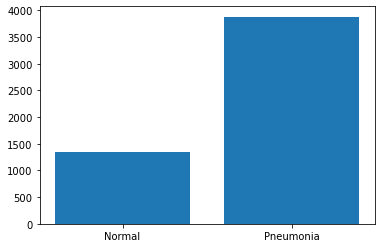

In [18]:
# Visualize class distribution in training data
plt.bar(x=['Normal', 'Pneumonia'], height=[len(train_normal_images), len(train_pneumonia_images)]);

Clearly not an even distribution! So many more pneumonia images, probably an over-representation.

## Loading images for modeling

We'll use the `ImageDataGenerator` class from Keras, as well as `flow_from_directory` to feed the images into the model.

In [66]:
def preprocess_dense_data(train_dir=train_dir, 
                          #val_dir=validation_dir, 
                          test_dir=test_dir, 
                          process_test=False,
                          return_class_weights=True,
                          target_size=(256, 256),
                          batch_size=100,
                          color_mode='grayscale',
                          class_mode='binary'):
    '''
    Prepare image data for fitting in a fully connected dense neural network by
    getting data from directories, scaling, and reshaping
    
    Parameters: directories for training, validation, and testing data.
    
    Returns: X_train, X_val, X_test, train_labels, val_labels, test_labels
    '''
    # Param-dict for 'flow_from_directory'
    directory_kwargs = {'target_size':target_size,
                        'batch_size':batch_size,
                        'color_mode':color_mode,
                        'class_mode':class_mode}
    
    # Get data from directories and scale
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    
    train_generator = train_datagen.flow_from_directory(train_dir, subset='training', **directory_kwargs)
    val_generator = train_datagen.flow_from_directory(train_dir, subset='validation', **directory_kwargs)
    # val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_dir, **directory_kwargs)
    
    if process_test:
        test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, **directory_kwargs)
    
    # Create the datasets
    train_images, train_labels = next(train_generator)
    val_images, val_labels = next(val_generator)
    if process_test:
        test_images, test_labels = next(test_generator)
    
    # Prepare images for modeling by reshaping
    def reshape_images(images):
        return images.reshape(images.shape[0], -1)
    
    X_train = reshape_images(train_images)
    X_val = reshape_images(val_images)
    
    if return_class_weights:
        # From https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory
        # Calculate floats/raw class weights
        class_weights = class_weight.compute_class_weight(
                       'balanced',
                        np.unique(train_generator.classes), 
                        train_generator.classes)

        # Convert to dict for .fit(class_weight= ) param
        nn_class_weights = {0:class_weights[0],
                            1:class_weights[1]}
    
        if process_test:
            X_test = reshape_images(test_images)
            return X_train, X_val, X_test, train_labels, val_labels, test_labels, nn_class_weights
        else:
            return X_train, X_val, train_labels, val_labels, nn_class_weights

In [29]:
X_train, X_val, train_labels, val_labels = preprocess_dense_data(target_size=(100, 100), 
                                                                 batch_size=50, 
                                                                 return_class_weights=False)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


## First Simple Model

Using simple fully connected Dense layers, no fancy stuff, no convolutions yet.

In [30]:
from keras import models
from keras.layers import Dense

In [31]:
# Instatiate model
model = models.Sequential()

# Add model layers
model.add(Dense(32, activation='relu', input_shape=(10000,)))
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc', 'Recall'])

In [32]:
# Train the model
history = model.fit(X_train, train_labels, 
                    epochs=50,
                    batch_size=10,
                    validation_data=(X_val, val_labels))

Epoch 1/50
5/5 [==============================] - 0s 56ms/step - loss: 0.6547 - acc: 0.6400 - recall: 0.8485 - val_loss: 0.8576 - val_acc: 0.3200 - val_recall: 0.0000e+00
Epoch 2/50
5/5 [==============================] - 0s 8ms/step - loss: 0.7982 - acc: 0.5400 - recall: 0.7576 - val_loss: 0.5895 - val_acc: 0.6800 - val_recall: 1.0000
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 0.6385 - acc: 0.6800 - recall: 0.8788 - val_loss: 0.5915 - val_acc: 0.6800 - val_recall: 1.0000
Epoch 4/50
5/5 [==============================] - 0s 10ms/step - loss: 0.5907 - acc: 0.6600 - recall: 1.0000 - val_loss: 0.5658 - val_acc: 0.6800 - val_recall: 1.0000
Epoch 5/50
5/5 [==============================] - 0s 6ms/step - loss: 0.5712 - acc: 0.7200 - recall: 1.0000 - val_loss: 0.5889 - val_acc: 0.6800 - val_recall: 1.0000
Epoch 6/50
5/5 [==============================] - 0s 6ms/step - loss: 0.5637 - acc: 0.7200 - recall: 0.9394 - val_loss: 0.5907 - val_acc: 0.8600 - val_recall: 0.941

5/5 [==============================] - 0s 7ms/step - loss: 0.1311 - acc: 1.0000 - recall: 1.0000 - val_loss: 0.2635 - val_acc: 0.9000 - val_recall: 0.8824


In [49]:
def visualize_training_results(results, model=None, X_train=None, train_labels=None, X_val=None, val_labels=None):
    '''
    Plot the training and validation data from a trained NN model, given the results/history.
    Plot accuracy, recall, and loss.
    
    If model and data are provided, print evaluation of training and validation data
    and plot confusion matrix.
    '''
    # Training history
    history = results.history
    
    # Accuracy
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['Validation acc', 'Training acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    # Recall
    plt.figure()
    plt.plot(history['val_recall'])
    plt.plot(history['recall'])
    plt.legend(['Validation recall', 'Training recall'])
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.show()
    
    # Loss
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['Validation loss', 'Training loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    # Evaluation
    if model and (X_train is not None) and (train_labels is not None):
        print('Training eval:')
        results_train = model.evaluate(X_train, train_labels)
    if (X_val is not None) and (val_labels is not None):
        print('\nValidation eval:')
        results_val = model.evaluate(X_val, val_labels)
        
    # Confusion matrix
    if model and (X_train is not None) and (train_labels is not None):
        y_preds = (model.predict(X_train) > 0.5).astype('int32')
        ConfusionMatrixDisplay(confusion_matrix(train_labels, y_preds), 
                           display_labels=['Normal', 'Pneumonia']).plot();

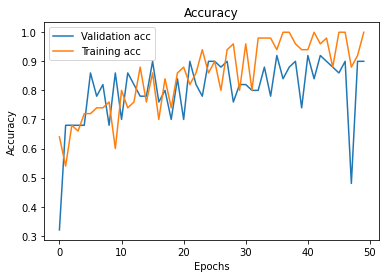

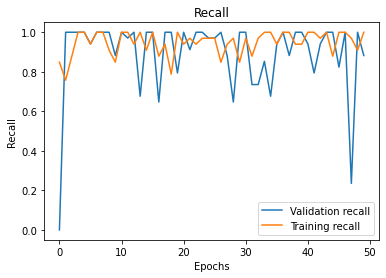

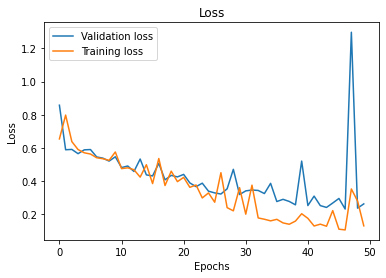

Training eval:
2/2 [==============================] - 0s 2ms/step - loss: 0.1021 - acc: 1.0000 - recall: 1.0000

Validation eval:
2/2 [==============================] - 0s 1ms/step - loss: 0.2635 - acc: 0.9000 - recall: 0.8824


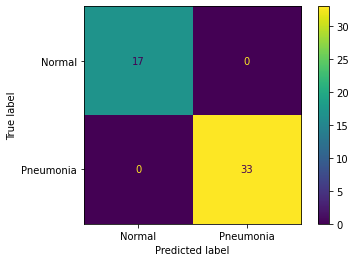

In [50]:
visualize_training_results(history, model, X_train, train_labels, X_val, val_labels)

**Analysis:**
Our FSM runs! Huzzah! However, the accuracy and loss are all over the place and overall poor, likely because:
 - we are only training it on 50 images
 - loss of data from resizing the images down to 150x150
 - class imbalance (in favor of Pneumonia lungs)

In [51]:
model.save('first-simple-model.h5')

## Iterating

Our model can definitely improve! The overfitting is likely due to way too few images being used in training, combined with a serious class imbalance in favor of the target class. Also, our model is very basic (only 1 hidden layer), so adding a 2nd hidden layer will likely help.

In [53]:
i1_X_train, i1_X_val, i1_train_labels, i1_val_labels = preprocess_dense_data()

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


### i1 (iteration one):
 - Bump up size of images to 256x256
 - Increase number of images to 100
 - Add a 2nd hidden layer

In [54]:
# Instatiate model
i1_model = models.Sequential()

# Add model layers - Let's add another hidden layer this time
i1_model.add(Dense(32, activation='relu', input_shape=(256*256,)))
i1_model.add(Dense(16, activation='relu'))
i1_model.add(Dense(1, activation='sigmoid'))

# Compile
i1_model.compile(optimizer='sgd',
                 loss='binary_crossentropy',
                 metrics=['acc', 'Recall'])

In [55]:
# Train the model
i1_history = i1_model.fit(i1_X_train, i1_train_labels, 
                    epochs=50,
                    batch_size=10,
                    validation_data=(i1_X_val, i1_val_labels))

Epoch 1/50
10/10 [==============================] - 0s 32ms/step - loss: 1.2145 - acc: 0.6000 - recall: 0.6974 - val_loss: 0.5826 - val_acc: 0.7300 - val_recall: 1.0000
Epoch 2/50
10/10 [==============================] - 0s 12ms/step - loss: 0.5716 - acc: 0.7600 - recall: 1.0000 - val_loss: 0.6373 - val_acc: 0.7300 - val_recall: 1.0000
Epoch 3/50
10/10 [==============================] - 0s 11ms/step - loss: 0.5541 - acc: 0.7600 - recall: 1.0000 - val_loss: 0.5479 - val_acc: 0.7300 - val_recall: 1.0000
Epoch 4/50
10/10 [==============================] - 0s 12ms/step - loss: 0.5328 - acc: 0.7600 - recall: 1.0000 - val_loss: 0.5377 - val_acc: 0.7300 - val_recall: 1.0000
Epoch 5/50
10/10 [==============================] - 0s 11ms/step - loss: 0.4556 - acc: 0.7600 - recall: 1.0000 - val_loss: 0.7466 - val_acc: 0.7300 - val_recall: 1.0000
Epoch 6/50
10/10 [==============================] - 0s 11ms/step - loss: 0.5548 - acc: 0.7600 - recall: 1.0000 - val_loss: 0.5093 - val_acc: 0.7300 - val_r

10/10 [==============================] - 0s 11ms/step - loss: 0.5543 - acc: 0.4900 - recall: 0.3289 - val_loss: 0.4858 - val_acc: 0.8500 - val_recall: 1.0000
Epoch 50/50
10/10 [==============================] - 0s 12ms/step - loss: 0.2270 - acc: 0.9500 - recall: 0.9605 - val_loss: 0.5760 - val_acc: 0.8300 - val_recall: 1.0000


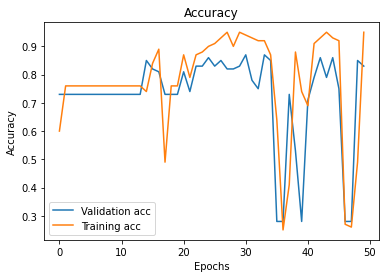

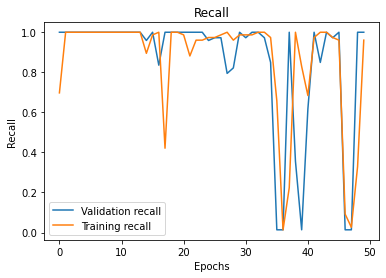

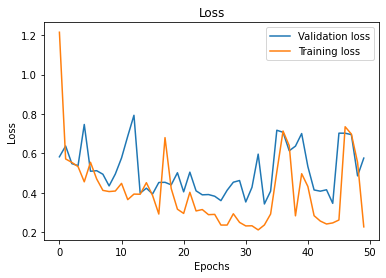

Training eval:
4/4 [==============================] - 0s 3ms/step - loss: 0.2184 - acc: 0.9200 - recall: 1.0000

Validation eval:
4/4 [==============================] - 0s 3ms/step - loss: 0.5760 - acc: 0.8300 - recall: 1.0000


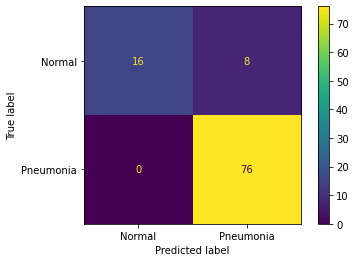

In [57]:
visualize_training_results(i1_history, i1_model, i1_X_train, i1_train_labels, i1_X_val, i1_val_labels)

Recall got better on validation, but accuracy dropped overall. It's slightly less overfit, but the accuracy/loss curves are still all over the place.

In [58]:
model.save('i1_model.h5')

### i2 (iteration two):
 - Include `class_weight` parameter during model fitting/training
 - Increase number of images to 500
 - Add a 3nd hidden layer

To get the class weights, I've gone back and added the option to return a dictionary `class_weights` from the `preprocess_dense_data` function.

In [63]:
i2_X_train, i2_X_val, i2_train_labels, i2_val_labels = preprocess_dense_data(batch_size=500)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [64]:
train_generator.classes

NameError: name 'train_generator' is not defined

In [ ]:
# From https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory
from sklearn.utils import class_weight

# Calculate floats/raw class weights
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

# Convert to dict for .fit(class_weight= ) param
nn_class_weights = {0:class_weights[0],
                    1:class_weights[1]}

In [ ]:
nn_class_weights

In [ ]:
# Instatiate model
i2_model = models.Sequential()

# Add model layers - Same as previous model
i2_model.add(Dense(32, activation='relu', input_shape=(256*256,)))
i2_model.add(Dense(16, activation='relu'))
i2_model.add(Dense(1, activation='sigmoid'))

# Compile
i2_model.compile(optimizer='sgd',
                 loss='binary_crossentropy',
                 metrics=['acc', 'Recall'])

In [ ]:
# Train the model - This time incorporating class_weights
i2_history = i2_model.fit(i2_X_train, i2_train_labels, 
                          epochs=50,
                          batch_size=10,
                          class_weight=nn_class_weights,
                          validation_data=(i2_X_val, i2_val_labels))

In [62]:
visualize_training_results(i2_history, i2_model, i2_X_train, i2_train_labels, i2_X_val, i2_val_labels)

NameError: name 'i2_history' is not defined

In [218]:
model.save('i2_model.h5')

Another improvement! Adding the `class_weight` parameter helped close the gap between training and validation data and increased overall accuracy. However, the metrics are still all over the place. Adding more data is likely to help, as could adding more hidden layers.

### i3 (iteration three):
 - Increase number of images to 2000
 - Add more hidden layers
 - Add l2 regularization to Dense layers (to help with overfitting)

In [226]:
from tensorflow.keras.regularizers import l2

In [223]:
i3_X_train, i3_X_val, i3_train_labels, i3_val_labels = preprocess_dense_data(batch_size=2000)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [224]:
# Calculate floats/raw class weights
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

# Convert to dict for .fit(class_weight= ) param
nn_class_weights = {0:class_weights[0],
                    1:class_weights[1]}

In [228]:
# Instatiate model
i3_model = models.Sequential()

# Add model layers - More layers and with l2 regularization
i3_model.add(Dense(32, activation='relu', input_shape=(256*256,)))
i3_model.add(Dense(20, activation='relu', kernel_regularizer=l2(l2=0.01)))
i3_model.add(Dense(12, activation='relu', kernel_regularizer=l2(l2=0.01)))
i3_model.add(Dense(12, activation='relu', kernel_regularizer=l2(l2=0.01)))
i3_model.add(Dense(8, activation='relu', kernel_regularizer=l2(l2=0.01)))
i3_model.add(Dense(4, activation='relu', kernel_regularizer=l2(l2=0.01)))
i3_model.add(Dense(1, activation='sigmoid', ))

# Compile
i3_model.compile(optimizer='sgd',
                 loss='binary_crossentropy',
                 metrics=['acc', 'Recall'])

In [229]:
# Train the model
i3_history = i3_model.fit(i3_X_train, i3_train_labels, 
                          epochs=100,
                          batch_size=32,
                          class_weight=nn_class_weights,
                          validation_data=(i3_X_val, i3_val_labels))

Epoch 1/100
63/63 [==============================] - 1s 18ms/step - loss: 1.3882 - acc: 0.5600 - recall: 0.5933 - val_loss: 1.3818 - val_acc: 0.5000 - val_recall: 1.0000
Epoch 2/100
63/63 [==============================] - 1s 13ms/step - loss: 1.3733 - acc: 0.6980 - recall: 0.8899 - val_loss: 1.3648 - val_acc: 0.5000 - val_recall: 1.0000
Epoch 3/100
63/63 [==============================] - 1s 14ms/step - loss: 1.3528 - acc: 0.7495 - recall: 0.9591 - val_loss: 1.3451 - val_acc: 0.5625 - val_recall: 1.0000
Epoch 4/100
63/63 [==============================] - 1s 14ms/step - loss: 1.3285 - acc: 0.7705 - recall: 0.8423 - val_loss: 1.3219 - val_acc: 0.6250 - val_recall: 0.3750
Epoch 5/100
63/63 [==============================] - 1s 15ms/step - loss: 1.2928 - acc: 0.6535 - recall: 0.5611 - val_loss: 1.2993 - val_acc: 0.6250 - val_recall: 1.0000
Epoch 6/100
63/63 [==============================] - 1s 14ms/step - loss: 1.2178 - acc: 0.7410 - recall: 0.7114 - val_loss: 1.2559 - val_acc: 0.6250 -

Epoch 49/100
63/63 [==============================] - 1s 23ms/step - loss: 0.3602 - acc: 0.9570 - recall: 0.9537 - val_loss: 0.4842 - val_acc: 0.9375 - val_recall: 1.0000
Epoch 50/100
63/63 [==============================] - 1s 14ms/step - loss: 0.3725 - acc: 0.9460 - recall: 0.9416 - val_loss: 0.6505 - val_acc: 0.9375 - val_recall: 1.0000
Epoch 51/100
63/63 [==============================] - 1s 14ms/step - loss: 0.3489 - acc: 0.9535 - recall: 0.9477 - val_loss: 0.5010 - val_acc: 0.9375 - val_recall: 1.0000
Epoch 52/100
63/63 [==============================] - 1s 14ms/step - loss: 0.3437 - acc: 0.9565 - recall: 0.9544 - val_loss: 0.5578 - val_acc: 0.9375 - val_recall: 1.0000
Epoch 53/100
63/63 [==============================] - 1s 13ms/step - loss: 0.3603 - acc: 0.9490 - recall: 0.9477 - val_loss: 0.6573 - val_acc: 0.9375 - val_recall: 1.0000
Epoch 54/100
63/63 [==============================] - 1s 14ms/step - loss: 0.3317 - acc: 0.9550 - recall: 0.9517 - val_loss: 0.8136 - val_acc: 0.

63/63 [==============================] - 1s 13ms/step - loss: 0.2145 - acc: 0.9565 - recall: 0.9517 - val_loss: 0.3661 - val_acc: 0.9375 - val_recall: 1.0000
Epoch 97/100
63/63 [==============================] - 1s 15ms/step - loss: 0.1927 - acc: 0.9620 - recall: 0.9591 - val_loss: 0.4489 - val_acc: 0.9375 - val_recall: 1.0000
Epoch 98/100
63/63 [==============================] - 1s 15ms/step - loss: 0.1818 - acc: 0.9715 - recall: 0.9685 - val_loss: 0.4889 - val_acc: 0.9375 - val_recall: 1.0000
Epoch 99/100
63/63 [==============================] - 1s 13ms/step - loss: 0.2033 - acc: 0.9610 - recall: 0.9597 - val_loss: 0.3960 - val_acc: 0.9375 - val_recall: 1.0000
Epoch 100/100
63/63 [==============================] - 1s 12ms/step - loss: 0.1970 - acc: 0.9620 - recall: 0.9584 - val_loss: 0.3516 - val_acc: 0.9375 - val_recall: 1.0000


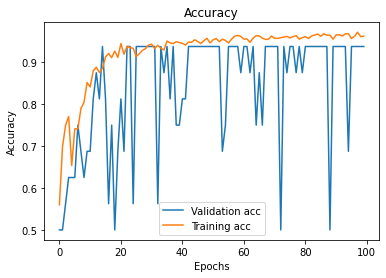

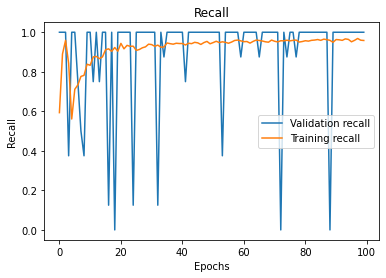

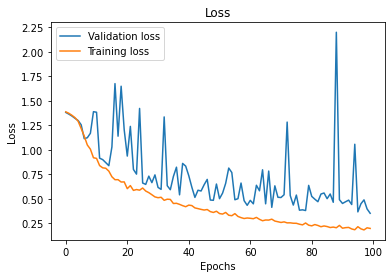

Training eval:
63/63 [==============================] - 0s 5ms/step - loss: 0.2148 - acc: 0.9585 - recall: 0.9443

Validation eval:
1/1 [==============================] - 0s 1ms/step - loss: 0.3516 - acc: 0.9375 - recall: 1.0000


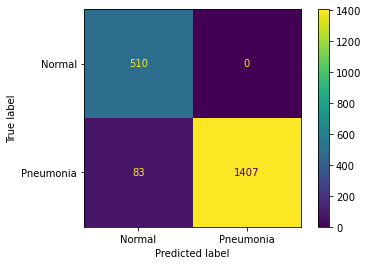

In [230]:
visualize_training_results(i3_history, i3_model, i3_X_train, i3_train_labels, i3_X_val, i3_val_labels)